# Pipeline example, internal migration

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import time

from vivarium import InteractiveContext
from vivarium.framework.configuration import build_simulation_configuration
from vivarium.config_tree import ConfigTree

from vivarium_public_health.population import InternalMigration
from vivarium_public_health.population.spenser_population import TestPopulation
from vivarium_public_health.population.spenser_population import transform_rate_table
from vivarium_public_health.population.spenser_population import prepare_dataset

from vivarium_public_health.utilities import read_config_file

## Base plugins for simulation

In [2]:
def base_plugins_simulation():
    config = {'required': {
                  'data': {
                      'controller': 'vivarium_public_health.testing.mock_artifact.MockArtifactManager',
                      'builder_interface': 'vivarium.framework.artifact.ArtifactInterface'
                  }
             }
    }

    return ConfigTree(config)

## Configure a simulation

In [3]:
def config_simulation(inp_file):
    
    if inp_file['prepare_data']['prepare']:
        # read a dataset (normally from daedalus), change columns to be readable by vivarium
        # this function creates a file saved at output_path
        prepare_dataset(
            dataset_path=inp_file['prepare_data']['path_to_dataset'], 
            output_path=inp_file['prepare_data']['path_to_output'],
            lookup_ethnicity=inp_file['prepare_data']['path_to_lookup_ethnicity'],
            columns_map=inp_file['prepare_data']['columns_map'],
            location_code=inp_file['prepare_data']['location_code']
        )
    
    # ============= CONFIGURATION
    if inp_file['configuration']['population']['population_size'] <= 0:
        pop_size = len(pd.read_csv(inp_file['paths']['path_to_pop_file']))
    else:
        pop_size = inp_file['configuration']['population']['population_size']
    
    # config object
    config = build_simulation_configuration()
    config.update({
        'time': {
            'start': inp_file['configuration']['time']['start'],
            'end': inp_file['configuration']['time']['end'],
            'step_size': inp_file['configuration']['time']['step_size']
        },
        'randomness': inp_file['configuration']['randomness'],
        'input_data': inp_file['configuration']['input_data'],
    }, 
        layer='model_override')
    
    config.update({
        'path_to_pop_file': inp_file['paths']['path_to_pop_file'],
        'path_to_internal_outmigration_file': inp_file['paths']['path_to_internal_outmigration_file'],
        'path_msoa_to_lad': inp_file['paths']['path_msoa_to_lad'],
        'path_to_OD_matrices': inp_file['paths']['path_to_OD_matrices'],
        'path_to_OD_matrix_index_file': inp_file['paths']['path_to_OD_matrix_index_file'],
        
        'population': {
            'population_size': pop_size,
            'age_start': inp_file['configuration']['population']['age_start'],
            'age_end': inp_file['configuration']['population']['age_end'],
        },
        },
    )
    
    return config

## Create an interactive context manager

In [4]:
inp_file = read_config_file("../config/model_specification_pipeline_006.yaml")

base_plugins = base_plugins_simulation()
config = config_simulation(inp_file=inp_file)
components = [eval(x) for x in inp_file["list_components"]]
simulation = InteractiveContext(components=components,
                                configuration=config,
                                plugin_configuration=base_plugins,
                                setup=False)




Write the dataset at: ../persistant_data/test_ssm_E08000032_MSOA11_ppp_2011.csv


## Internal migration rates

In [5]:
df = pd.read_csv(config.path_to_internal_outmigration_file)

# to save time, only look at locations existing on the test dataset.
df_internal_outmigration = df[df['LAD.code'].isin(['E08000032', 
                                                   'E08000033', 
                                                   'E08000034',
                                                   'E06000024',
                                                   'E08000035',
                                                   'E07000163'])]
#df_internal_outmigration = df.copy()

asfr_data = transform_rate_table(df_internal_outmigration, 
                                 2011, 
                                 2012, 
                                 config.population.age_start,
                                 config.population.age_end)
simulation._data.write("cause.age_specific_internal_outmigration_rate", asfr_data)

In [6]:
asfr_data.head()

,age_end,age_start,ethnicity,location,mean_value,sex,year_end,year_start
0,1,0,BAN,E06000024,0.060981,1,2012,2011
1,2,1,BAN,E06000024,0.045308,1,2012,2011
2,3,2,BAN,E06000024,0.048982,1,2012,2011
3,4,3,BAN,E06000024,0.070046,1,2012,2011
4,5,4,BAN,E06000024,0.019269,1,2012,2011


In [7]:
# Read MSOA ---> LAD
msoa_lad_df = pd.read_csv(config.path_msoa_to_lad)
# Read OD matrix, only destinations
OD_matrix_dest = pd.read_csv(config.path_to_OD_matrix_index_file,index_col=0)
OD_matrix_with_LAD = OD_matrix_dest.merge(msoa_lad_df[["MSOA11CD", "LAD16CD"]],left_index=True,
                                              right_on="MSOA11CD")

OD_matrix_with_LAD.index = OD_matrix_with_LAD["indices"]

# Create indices for MSOA and LAD
MSOA_location_index = OD_matrix_with_LAD["MSOA11CD"].to_dict()
LAD_location_index = OD_matrix_with_LAD["LAD16CD"].to_dict()

# Now, read the whole matrix (if it passes the first check)
simulation._data.write("internal_migration.MSOA_index", MSOA_location_index)
simulation._data.write("internal_migration.LAD_index", LAD_location_index)
simulation._data.write("internal_migration.MSOA_LAD_indices", OD_matrix_with_LAD)
simulation._data.write("internal_migration.path_to_OD_matrices", config.path_to_OD_matrices)

In [8]:
OD_matrix_with_LAD.head()

,indices,MSOA11CD,LAD16CD
indices,,,
0,0,E02000001,E09000001
1,1,E02000002,E09000002
2,2,E02000003,E09000002
3,3,E02000004,E09000002
4,4,E02000005,E09000002


## Setup a simulation and run for `num_days`

In [9]:
sim_start = time.time()

simulation.setup()
num_days = 365*1 + 5
simulation.run_for(duration=pd.Timedelta(days=num_days))

sim_end = time.time()

2020-09-14 19:11:52.420 | DEBUG    | vivarium.framework.values:register_value_modifier:373 - Registering metrics.1.population_manager.metrics as modifier to metrics
2020-09-14 19:12:16.375 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline int_outmigration_rate
2020-09-14 19:12:28.821 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline metrics


2020-09-14 19:13:16.559 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-01 00:00:00
2020-09-14 19:13:18.312 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-11 00:00:00
2020-09-14 19:13:20.264 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-21 00:00:00
2020-09-14 19:13:22.186 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-31 00:00:00
2020-09-14 19:13:23.942 | DEBUG    | vivarium.framework.engine:step:140 - 2011-02-10 00:00:00
2020-09-14 19:13:26.119 | DEBUG    | vivarium.framework.engine:step:140 - 2011-02-20 00:00:00
2020-09-14 19:13:28.293 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-02 00:00:00
2020-09-14 19:13:30.140 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-12 00:00:00
2020-09-14 19:13:31.868 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-22 00:00:00
2020-09-14 19:13:33.612 | DEBUG    | vivarium.framework.engine:step:140 - 2011-04-01 00:00:00
2020-09-14 19:13:35.509 | DEBUG    | vivarium.framework.engi

In [10]:
pop = simulation.get_population()
pop.head()

,tracked,last_outmigration_time,internal_outmigration,previous_MSOA_locations,previous_LAD_locations,sex,MSOA,location,age,exit_time,entrance_time,ethnicity,alive
0,True,NaT,No,,,1,E02002183,E08000032,2.013699,NaT,2010-12-22,WBI,alive
1,True,NaT,No,,,1,E02002183,E08000032,2.013699,NaT,2010-12-22,WBI,alive
2,True,NaT,No,,,1,E02002183,E08000032,2.013699,NaT,2010-12-22,WBI,alive
3,True,NaT,No,,,1,E02002183,E08000032,2.013699,NaT,2010-12-22,WBI,alive
4,True,NaT,No,,,1,E02002183,E08000032,2.013699,NaT,2010-12-22,WBI,alive


In [11]:
print(f"Total time: {sim_end - sim_start}")
print('internal outmigration',len(pop[pop['internal_outmigration'] == 'Yes']))
print('remaining population',len(pop[pop['internal_outmigration'] == 'No']))

Total time: 149.61166310310364
internal outmigration 16386
remaining population 506035


In [12]:
migrant_pool = pop[pop['internal_outmigration'] == 'Yes']
migrant_pool.head()

,tracked,last_outmigration_time,internal_outmigration,previous_MSOA_locations,previous_LAD_locations,sex,MSOA,location,age,exit_time,entrance_time,ethnicity,alive
12,True,2011-09-08,Yes,E02002183,E08000032,1,E02002209,E08000032,2.013699,NaT,2010-12-22,WBI,alive
41,True,2011-10-28,Yes,E02002183,E08000032,1,E02002209,E08000032,3.013699,NaT,2010-12-22,WBI,alive
54,True,2011-03-22,Yes,E02002183,E08000032,1,E02002209,E08000032,4.013699,NaT,2010-12-22,WBI,alive
83,True,2011-11-27,Yes,E02002183,E08000032,1,E02002209,E08000032,5.013699,NaT,2010-12-22,WBI,alive
102,True,2011-09-18,Yes,E02002183,E08000032,1,E02005808,E07000168,6.013699,NaT,2010-12-22,WBI,alive


## Plot results

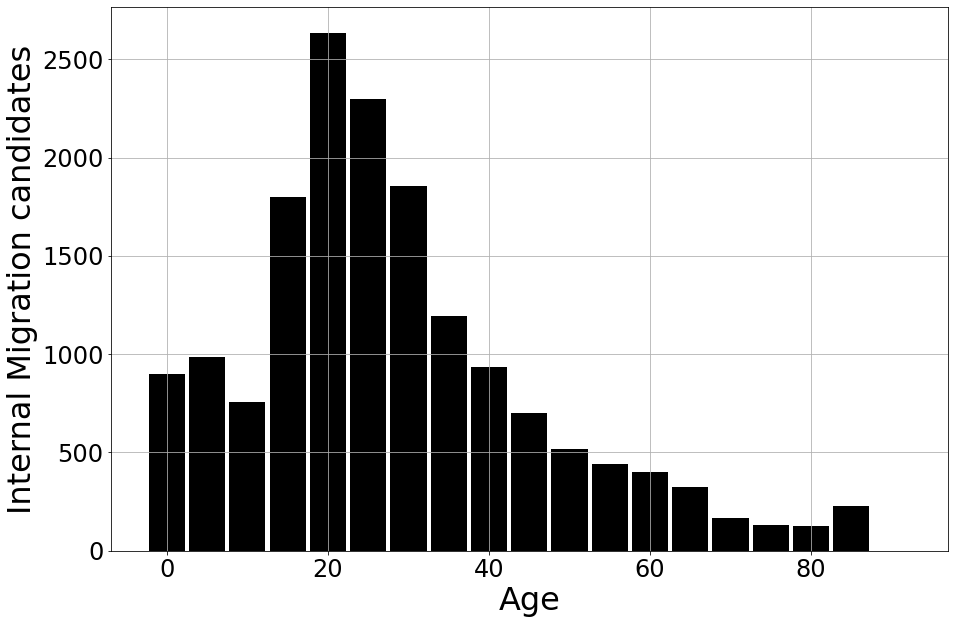

In [13]:
plt.figure(figsize=(15, 10))

migrant_pool["age"].hist(bins=range(0, 100, 5), 
                     rwidth=0.9, 
                     color='k',
                     align='left'
                    )
plt.xlabel("Age", size=32)
plt.ylabel("Internal Migration candidates", size=32)
plt.xticks(size=24)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()

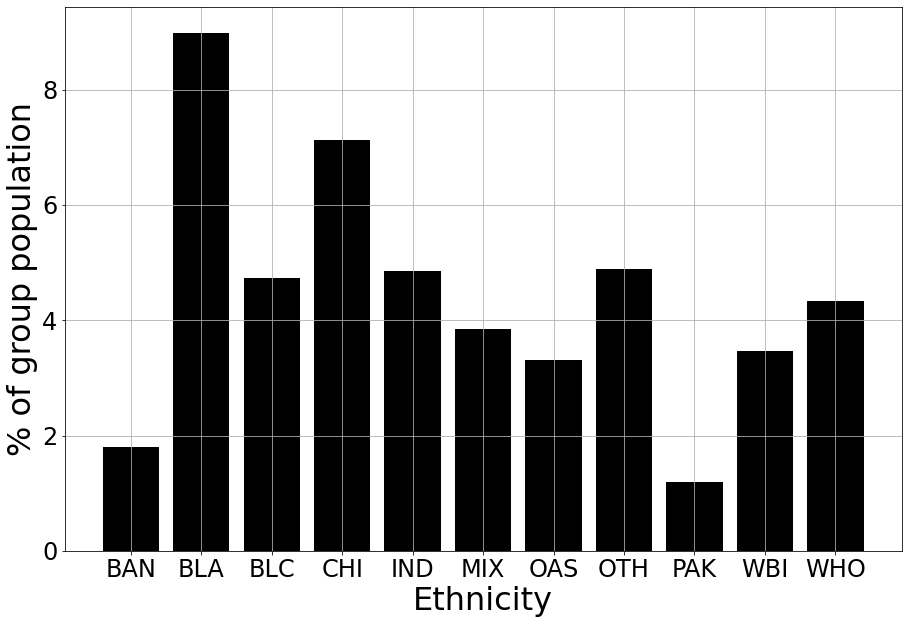

In [14]:
series2plot = migrant_pool['ethnicity'].value_counts() / pop["ethnicity"].value_counts() * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Ethnicity", size=32)
plt.ylabel("% of group population", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

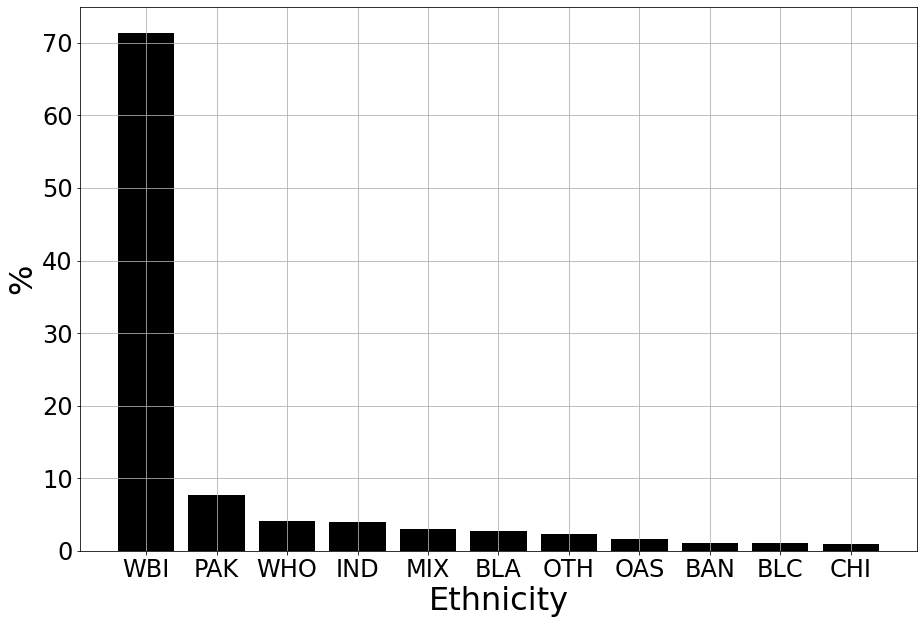

In [15]:
series2plot = migrant_pool['ethnicity'].value_counts() / len(migrant_pool["ethnicity"]) * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Ethnicity", size=32)
plt.ylabel("%", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

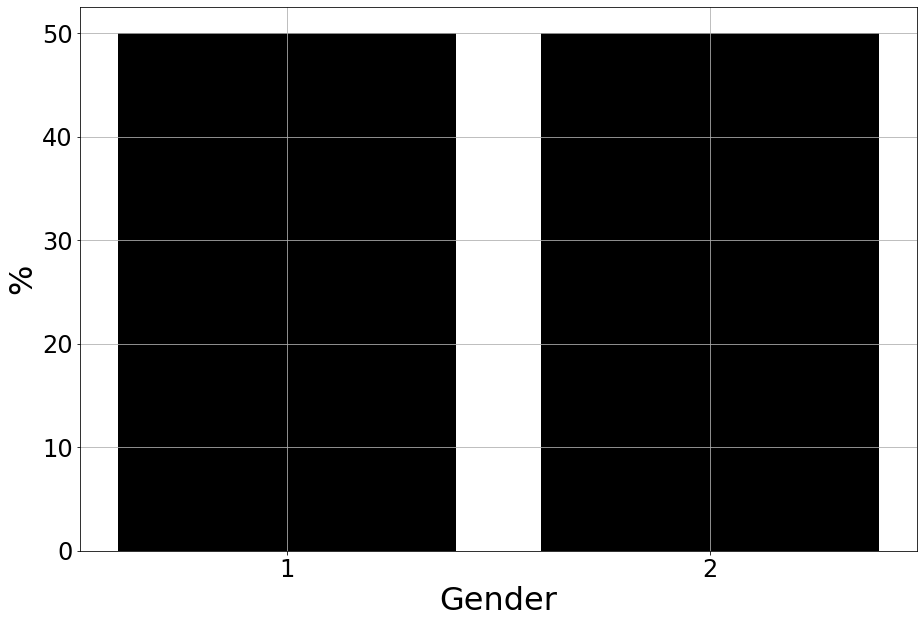

In [16]:
series2plot = migrant_pool['sex'].value_counts() / len(migrant_pool["sex"]) * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Gender", size=32)
plt.ylabel("%", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

/Users/khosseini/myJobs/ATI/Projects/2019/SPENCER/vivarium_public_health_spenser/venv/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


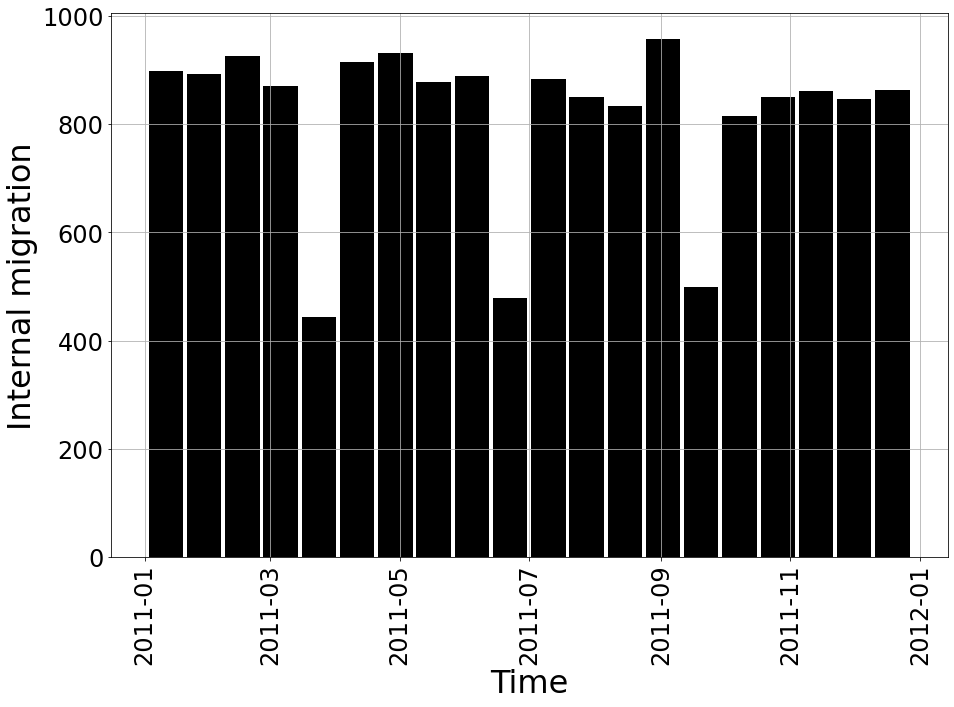

In [17]:
plt.figure(figsize=(15, 10))

migrant_pool["last_outmigration_time"].hist(bins=20, 
                                            rwidth=0.9, 
                                            color='k',
                                            align='left'
                                            )
plt.xlabel("Time", size=32)
plt.ylabel("Internal migration", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()

In [18]:
#min_time = pop["entrance_time"].min().strftime("%Y-%m-%d")
min_time = "2011-01-01"
max_time = datetime.datetime.strptime("2011-12-31", "%Y-%m-%d")

print("min_time:", min_time)
print("max_time:", max_time)

min_time: 2011-01-01
max_time: 2011-12-31 00:00:00


In [19]:
# --- input
# intervals for plotting (in days)
interval_in_days = 10
# list of ethnicities
sel_ethnicity = ["WBI", "WHO"]

# Population (total, for selected ethnicities, gender)
total_population = len(pop)
total_population_ETH = len(pop[pop["ethnicity"].isin(sel_ethnicity)])
total_population_male = len(pop[pop["sex"] == 1])
total_population_female = len(pop[pop["sex"] == 2])

time_axis = []
population_axis = []
population_ETH_axis = []
population_M_axis = []
population_F_axis = []

curr_time = datetime.datetime.strptime(min_time, "%Y-%m-%d")
while curr_time <= max_time:
    time_axis.append(curr_time)
    
    # dead population until current time (changes in the while loop)
    pop_dead = pop[pop["last_outmigration_time"] <= curr_time.strftime("%Y-%m-%d")]
    
    num_dead_population = total_population - len(pop_dead)
    population_axis.append(num_dead_population)
    
    num_dead_population_eth = total_population_ETH - len(pop_dead[pop_dead["ethnicity"].isin(sel_ethnicity)])
    population_ETH_axis.append(num_dead_population_eth)
    
    num_dead_male = total_population_male - len(pop_dead[pop_dead["sex"] == 1])
    population_M_axis.append(num_dead_male)
    
    num_dead_female = total_population_female - len(pop_dead[pop_dead["sex"] == 2])
    population_F_axis.append(num_dead_female)
    
    # go to next time, according to the selected interval_in_days
    curr_time = datetime.datetime.strptime(curr_time.strftime("%Y-%m-%d"), "%Y-%m-%d")
    curr_time += datetime.timedelta(days=interval_in_days)

In [20]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

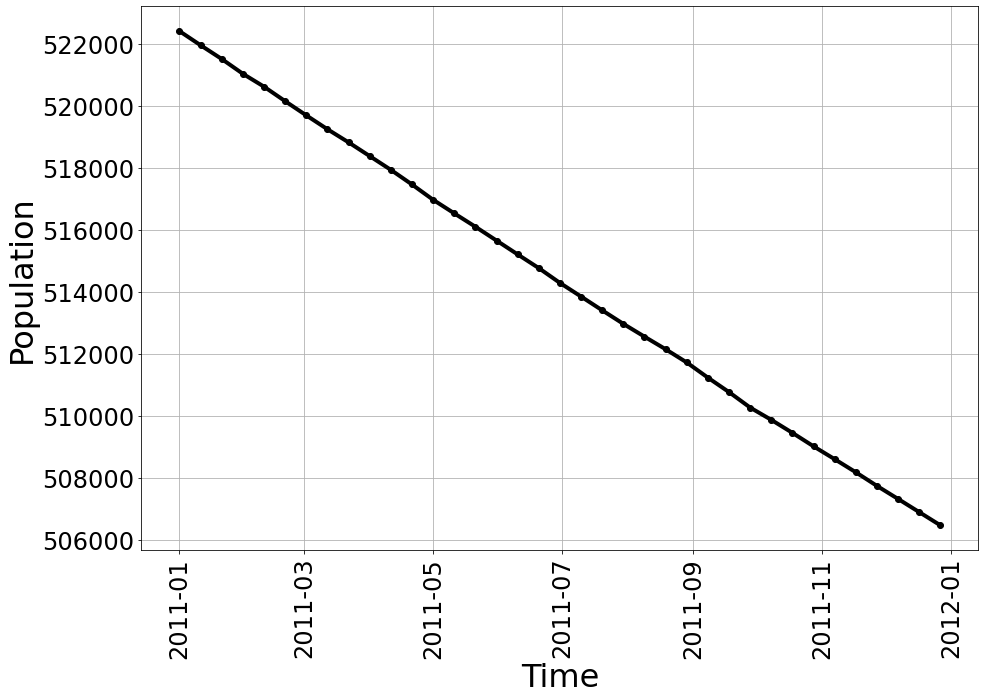

In [21]:
# Population (total)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, population_axis, 
         c='k', lw=4, marker="o")
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.show()

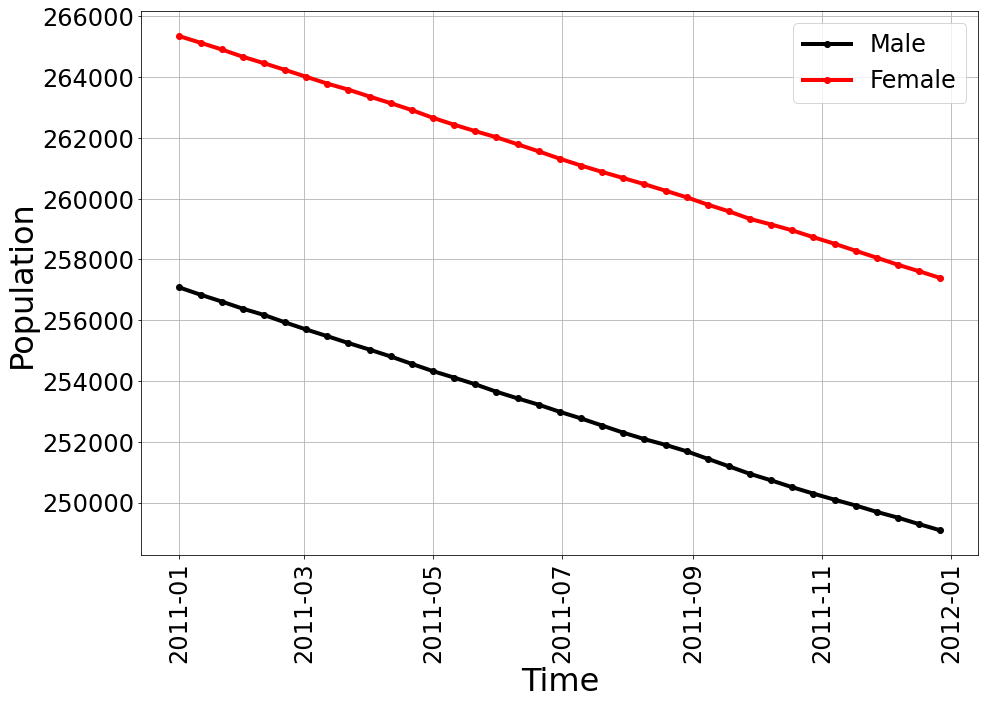

In [22]:
# Population (gender)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, population_M_axis, 
         c='k', lw=4, marker="o", 
         label="Male"
        )
plt.plot(time_axis, population_F_axis, 
         c='r', lw=4, marker="o",
         label="Female"
        )
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()

In [23]:
print(migrant_pool.shape)
migrant_pool.head()

(16386, 13)


,tracked,last_outmigration_time,internal_outmigration,previous_MSOA_locations,previous_LAD_locations,sex,MSOA,location,age,exit_time,entrance_time,ethnicity,alive
12,True,2011-09-08,Yes,E02002183,E08000032,1,E02002209,E08000032,2.013699,NaT,2010-12-22,WBI,alive
41,True,2011-10-28,Yes,E02002183,E08000032,1,E02002209,E08000032,3.013699,NaT,2010-12-22,WBI,alive
54,True,2011-03-22,Yes,E02002183,E08000032,1,E02002209,E08000032,4.013699,NaT,2010-12-22,WBI,alive
83,True,2011-11-27,Yes,E02002183,E08000032,1,E02002209,E08000032,5.013699,NaT,2010-12-22,WBI,alive
102,True,2011-09-18,Yes,E02002183,E08000032,1,E02005808,E07000168,6.013699,NaT,2010-12-22,WBI,alive


## Plot on map

In [24]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pyproj import Transformer

In [25]:
transformer = Transformer.from_crs('EPSG:27700', 'EPSG:4326')

def calcLatLon(row, transformer):
    return transformer.transform(row["X"], row["Y"])

In [26]:
# read centroid file
msoa_centroids = pd.read_csv("../persistant_data/Middle_Layer_Super_Output_Areas__December_2001__Population_Weighted_Centroids.csv")

In [27]:
# Calculate coordinates based on centroid file
msoa_centroids["coord"] = \
        msoa_centroids.apply(calcLatLon, transformer=transformer, axis=1)
msoa_centroids[["lat", "lon"]] = \
        pd.DataFrame(msoa_centroids['coord'].to_list(), columns=["lat", "lon"])

In [28]:
msoa_centroids.head()

,X,Y,objectid,msoa01cd,msoa01nm,coord,lat,lon
0,532458,181630,1,E02000001,City of London 001,"(51.51806856390007, -0.09234820740685304)",51.518069,-0.092348
1,547997,189392,2,E02000002,Barking and Dagenham 001,"(51.583957628785356, 0.13471150340955101)",51.583958,0.134712
2,548377,188094,3,E02000003,Barking and Dagenham 002,"(51.572195177887295, 0.13964420605725175)",51.572195,0.139644
3,550921,186823,4,E02000004,Barking and Dagenham 003,"(51.56010074279055, 0.17577984757488016)",51.560101,0.175780
4,548707,186820,5,E02000005,Barking and Dagenham 004,"(51.56066134179762, 0.1438638317731335)",51.560661,0.143864


In [29]:
migrant_pool[["prev_MSOA_lat", "prev_MSOA_lon"]] = \
            migrant_pool[["previous_MSOA_locations"]].merge(msoa_centroids[["msoa01cd", "lat", "lon"]], 
                                                            left_on="previous_MSOA_locations", 
                                                            right_on="msoa01cd")[["lat", "lon"]]

/Users/khosseini/myJobs/ATI/Projects/2019/SPENCER/vivarium_public_health_spenser/venv/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [30]:
migrant_pool[["MSOA_lat", "MSOA_lon"]] = \
            migrant_pool[["MSOA"]].merge(msoa_centroids[["msoa01cd", "lat", "lon"]], 
                                                         left_on="MSOA", 
                                                         right_on="msoa01cd")[["lat", "lon"]]

In [31]:
migrant_pool.head()

,tracked,last_outmigration_time,internal_outmigration,previous_MSOA_locations,previous_LAD_locations,sex,MSOA,location,age,exit_time,entrance_time,ethnicity,alive,prev_MSOA_lat,prev_MSOA_lon,MSOA_lat,MSOA_lon
12,True,2011-09-08,Yes,E02002183,E08000032,1,E02002209,E08000032,2.013699,NaT,2010-12-22,WBI,alive,53.937269,-1.866894,53.818224,-1.712479
41,True,2011-10-28,Yes,E02002183,E08000032,1,E02002209,E08000032,3.013699,NaT,2010-12-22,WBI,alive,53.937269,-1.866894,53.818224,-1.712479
54,True,2011-03-22,Yes,E02002183,E08000032,1,E02002209,E08000032,4.013699,NaT,2010-12-22,WBI,alive,53.937269,-1.866894,53.818224,-1.712479
83,True,2011-11-27,Yes,E02002183,E08000032,1,E02002209,E08000032,5.013699,NaT,2010-12-22,WBI,alive,53.937269,-1.866894,53.818224,-1.712479
102,True,2011-09-18,Yes,E02002183,E08000032,1,E02005808,E07000168,6.013699,NaT,2010-12-22,WBI,alive,53.937269,-1.866894,53.818224,-1.712479


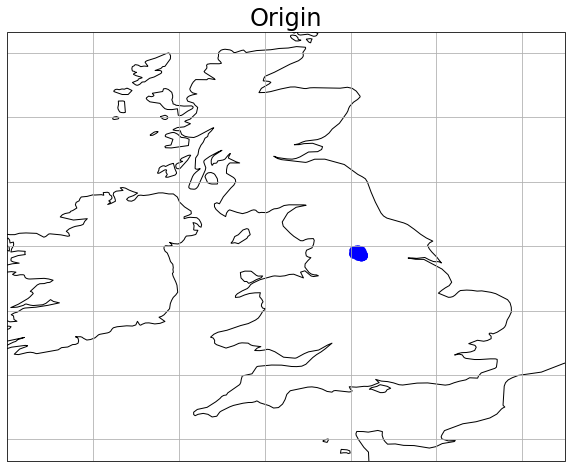

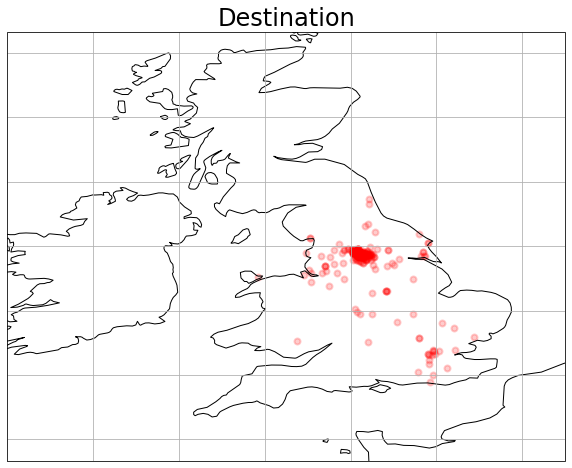

In [32]:
uk_extent = [-10, 3, 49, 59]
plain_crs = ccrs.PlateCarree()

plt.figure(figsize=(10, 20))
ax = plt.axes(projection=plain_crs)
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_extent(uk_extent, crs=plain_crs)

ax.scatter(migrant_pool["prev_MSOA_lon"],
           migrant_pool["prev_MSOA_lat"],
           color='blue', linewidth=2, 
           marker='o', alpha=0.2,
           transform=plain_crs)
plt.title("Origin", size=24)

plt.figure(figsize=(10, 20))
ax = plt.axes(projection=plain_crs)
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_extent(uk_extent, crs=plain_crs)

ax.scatter(migrant_pool["MSOA_lon"],
           migrant_pool["MSOA_lat"],
           color='red', linewidth=2, 
           marker='o', alpha=0.2,
           transform=plain_crs)
plt.title("Destination", size=24)

plt.show()

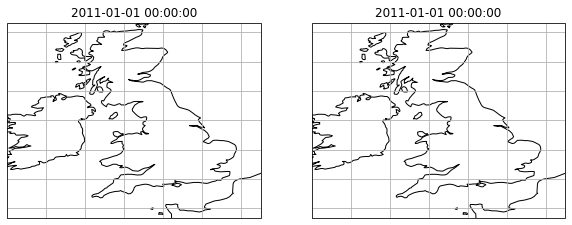

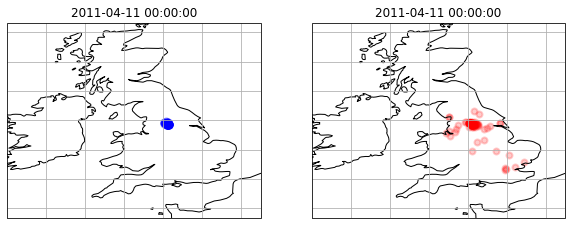

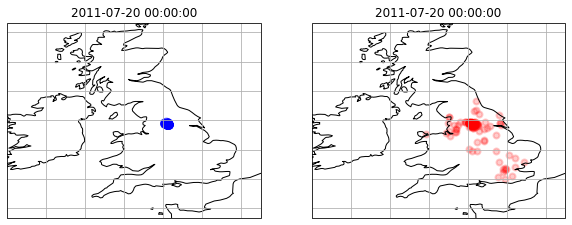

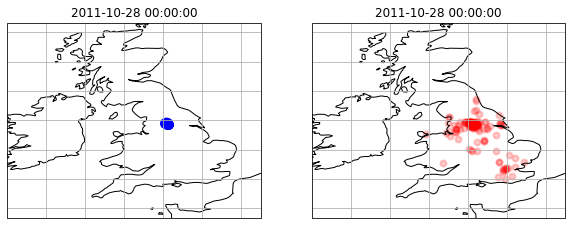

In [33]:
#min_time = pop["entrance_time"].min().strftime("%Y-%m-%d")
min_time = "2011-01-01"
max_time = datetime.datetime.strptime("2011-12-31", "%Y-%m-%d")
uk_extent = [-10, 3, 49, 59]
plain_crs = ccrs.PlateCarree()

# --- input
# intervals for plotting (in days)
interval_in_days = 100
curr_time = datetime.datetime.strptime(min_time, "%Y-%m-%d")

while curr_time <= max_time:
    time_axis.append(curr_time)
    
    # dead population until current time (changes in the while loop)
    migrant_pool_curr = migrant_pool[migrant_pool["last_outmigration_time"] <= curr_time.strftime("%Y-%m-%d")]

    plt.figure(figsize=(10, 20))
    ax = plt.subplot(1, 2, 1, projection=plain_crs)
    ax.coastlines(resolution='50m')
    ax.gridlines()
    ax.set_extent(uk_extent, crs=plain_crs)
    
    ax.scatter(migrant_pool_curr["prev_MSOA_lon"],
           migrant_pool_curr["prev_MSOA_lat"],
           color='blue', linewidth=2, 
           marker='o', alpha=0.2,
           transform=plain_crs)
    plt.title(curr_time)
    
    ax = plt.subplot(1, 2, 2, projection=plain_crs)
    ax.coastlines(resolution='50m')
    ax.gridlines()
    ax.set_extent(uk_extent, crs=plain_crs)
    ax.scatter(migrant_pool_curr["MSOA_lon"],
           migrant_pool_curr["MSOA_lat"],
           color='red', linewidth=2, 
           marker='o', alpha=0.2,
           transform=plain_crs)
    plt.title(curr_time)
    
#     ax.plot([migrant_pool_curr["prev_MSOA_lon"],migrant_pool_curr["MSOA_lon"]], 
#              [migrant_pool_curr["prev_MSOA_lat"],migrant_pool_curr["MSOA_lat"]],
#              color='k', linewidth=2, alpha=0.1,
#              transform=ccrs.Geodetic(),
#              )
    plt.show()
    
    # go to next time, according to the selected interval_in_days
    curr_time = datetime.datetime.strptime(curr_time.strftime("%Y-%m-%d"), "%Y-%m-%d")
    curr_time += datetime.timedelta(days=interval_in_days)

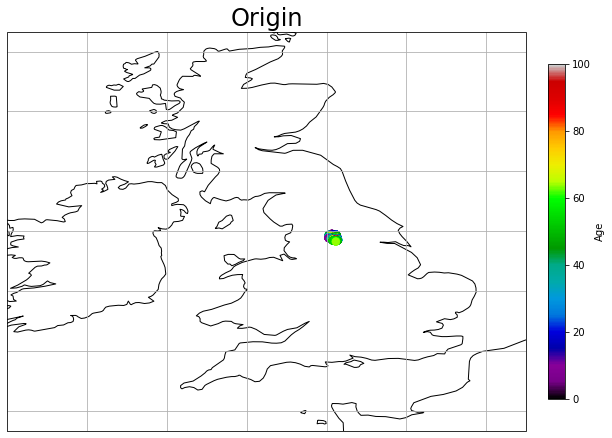

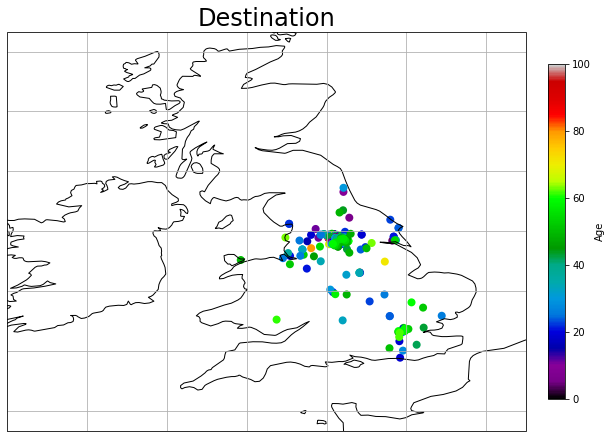

In [34]:
uk_extent = [-10, 3, 49, 59]
plain_crs = ccrs.PlateCarree()
cm = plt.cm.get_cmap('nipy_spectral')

plt.figure(figsize=(10, 20))
ax = plt.axes(projection=plain_crs)
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_extent(uk_extent, crs=plain_crs)

sc = ax.scatter(migrant_pool["prev_MSOA_lon"],
           migrant_pool["prev_MSOA_lat"],
           c=migrant_pool["age"], 
           linewidth=2, marker='o',
           cmap=cm,
           vmin=0, vmax=100,
           transform=plain_crs,
           )
cbar = plt.colorbar(sc, fraction=0.03, pad=0.04)
cbar.set_label("Age")
plt.title("Origin", size=24)

plt.figure(figsize=(10, 20))
ax = plt.axes(projection=plain_crs)
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_extent(uk_extent, crs=plain_crs)

ax.scatter(migrant_pool["MSOA_lon"],
           migrant_pool["MSOA_lat"],
           c=migrant_pool["age"], 
           linewidth=2, marker='o',
           cmap=cm,
           vmin=0, vmax=100,
           transform=plain_crs,
           )
cbar = plt.colorbar(sc, fraction=0.03, pad=0.04)
cbar.set_label("Age")
plt.title("Destination", size=24)

plt.show()

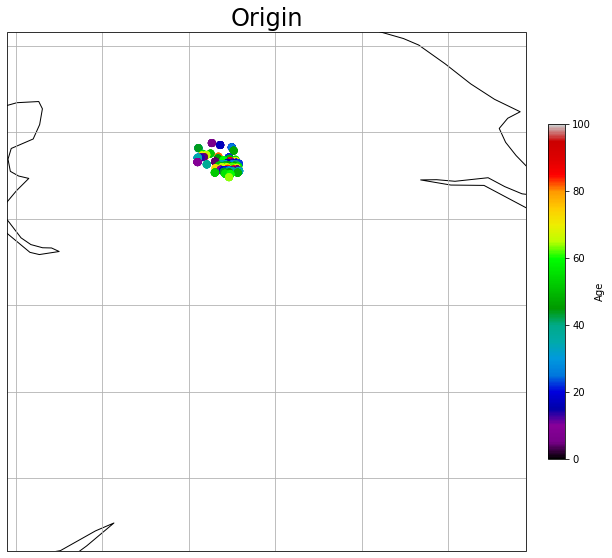

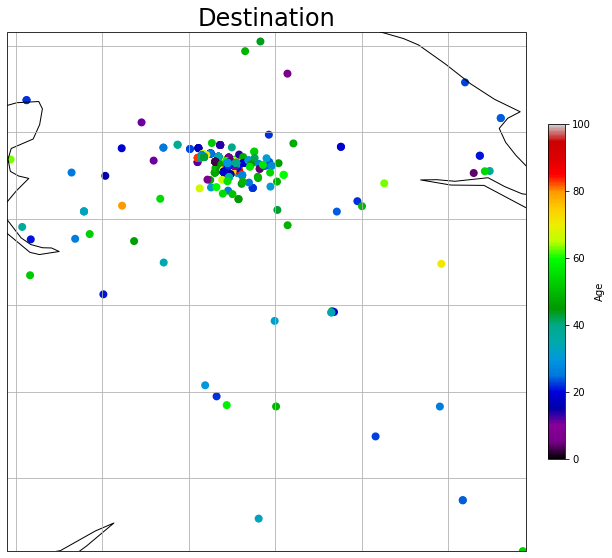

In [35]:
plain_crs = ccrs.PlateCarree()
cm = plt.cm.get_cmap('nipy_spectral')

dx = dy = 1.5
uk_extent = [-1.55-dx, -1.55+dx, 53.08-dy, 53.08+dy]

plt.figure(figsize=(10, 20))
ax = plt.axes(projection=plain_crs)
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_extent(uk_extent, crs=plain_crs)

sc = ax.scatter(migrant_pool["prev_MSOA_lon"],
           migrant_pool["prev_MSOA_lat"],
           c=migrant_pool["age"], 
           linewidth=2, marker='o',
           cmap=cm,
           vmin=0, vmax=100,
           transform=plain_crs,
           )
cbar = plt.colorbar(sc, fraction=0.03, pad=0.04)
cbar.set_label("Age")
plt.title("Origin", size=24)

plt.figure(figsize=(10, 20))
ax = plt.axes(projection=plain_crs)
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_extent(uk_extent, crs=plain_crs)

ax.scatter(migrant_pool["MSOA_lon"],
           migrant_pool["MSOA_lat"],
           c=migrant_pool["age"], 
           linewidth=2, marker='o',
           cmap=cm,
           vmin=0, vmax=100,
           transform=plain_crs,
           )
cbar = plt.colorbar(sc, fraction=0.03, pad=0.04)
cbar.set_label("Age")
plt.title("Destination", size=24)

plt.show()

In [ ]:
# PLOT on google earth
# installation: 
# !pip install simplekml
# import os
# import simplekml

# # Create an instance of Kml
# kml = simplekml.Kml()

# for index, row in migrant_pool.iterrows():
# #     pnt = kml.newpoint()
# #     pnt.name = str(index)
# #     pnt.coords = [(row["prev_MSOA_lon"],row["prev_MSOA_lat"])]
    
# #     pnt = kml.newpoint()
# #     pnt.name = str(index)
# #     pnt.coords = [(row["MSOA_lon"],row["MSOA_lat"])]
    
#     ls = kml.newlinestring(name='A LineString')
#     ls.coords = [(row["prev_MSOA_lon"],row["prev_MSOA_lat"],50),
#                  (row["MSOA_lon"],row["MSOA_lat"],50)]
#     ls.extrude = 1
#     ls.altitudemode = simplekml.AltitudeMode.clamptoground
#     ls.style.linestyle.width = 1
#     ls.style.linestyle.color = simplekml.Color.red

# # Save the KML
# kml.save("test.kml")